In [19]:
remove(list = ls())
source("../../R/JGL.R")
source("../../R/admm.iters.R")
source("../../R/gete.R")
source("../../R/SSJGL.R")
source("../../R/eval.R")
source("../../R/metrics.R")
library(latex2exp)
library(BDgraph)
library(viridis)

library(tmvtnorm)
library(JGL)
library(corrplot)
library(Matrix)
library(network)
library(intergraph)
library(progress)

In [20]:
path <- "../../figures/simple_example_ssjgl/"
ID <- "001"

Warning message in text.default(pos.xlabel[, 1], pos.xlabel[, 2], newcolnames, srt = tl.srt, :
“"cl.lim" is not a graphical parameter”Warning message in text.default(pos.ylabel[, 1], pos.ylabel[, 2], newrownames, col = tl.col, :
“"cl.lim" is not a graphical parameter”Warning message in title(title, ...):
“"cl.lim" is not a graphical parameter”Warning message in text.default(pos.xlabel[, 1], pos.xlabel[, 2], newcolnames, srt = tl.srt, :
“"cl.lim" is not a graphical parameter”Warning message in text.default(pos.ylabel[, 1], pos.ylabel[, 2], newrownames, col = tl.col, :
“"cl.lim" is not a graphical parameter”Warning message in title(title, ...):
“"cl.lim" is not a graphical parameter”

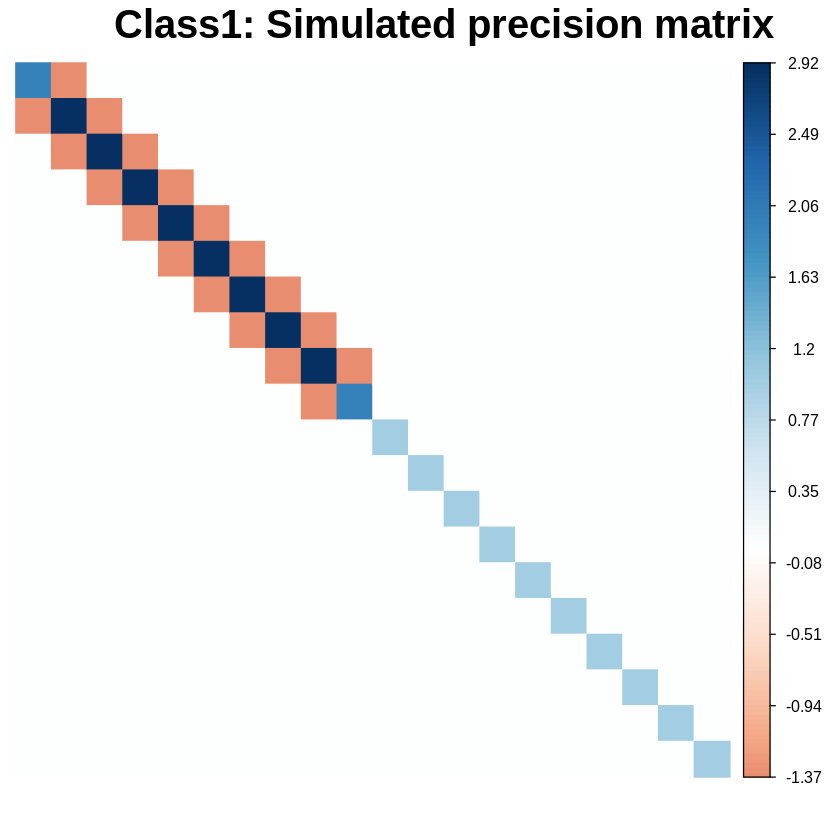

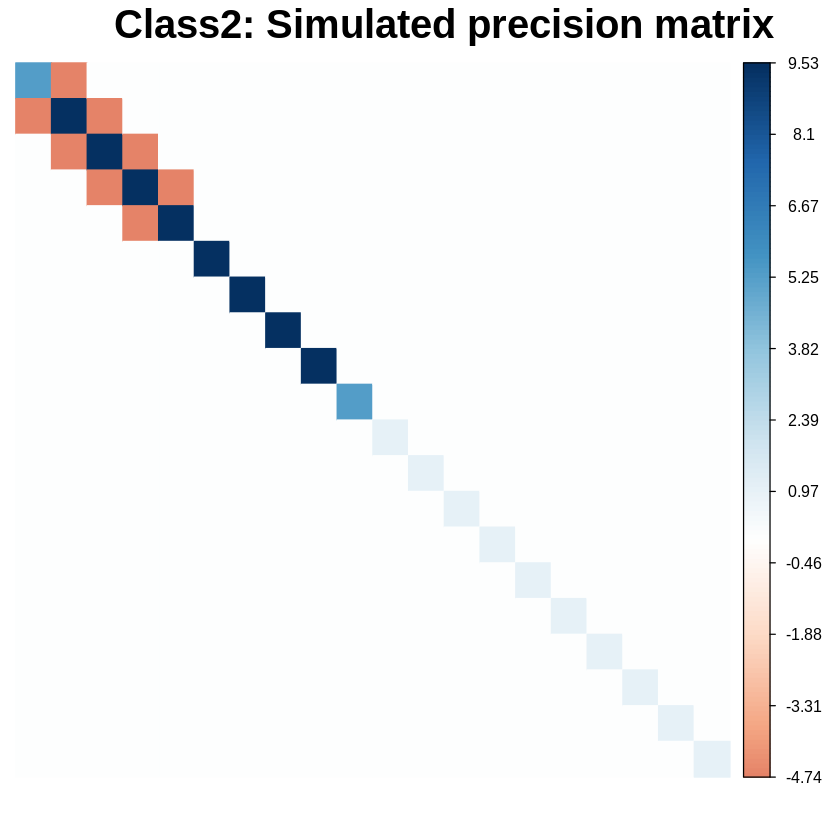

In [21]:
P <- 10 #dimension
PP <- 100
N <- rep(150, 2)
g_num <- 2
#rho <- runif(2, min = 0, max = 1)
rho <- c(0.7, 0.9)
remove <- 4
data <- g <- thetatrue <- NULL

#generate s1, #G is the adjacent matirx
s1 <- bdgraph.sim.rho(n = 1, p = P, vis = FALSE, graph = "AR1")$G #vis:visualize the true graph
diag(s1) <- 0

#generate s2
s2 <- bdgraph.sim.rho(n = 1, p = P/2, vis = FALSE, graph = "AR1")$G
diag(s2) <- 0
s2 <- bdiag(s2, diag(0, P/2))

s0 <- matrix(0, PP - P, PP - P)
#bdiag means block diagonal matrix
g[[1]] <- as.matrix(bdiag(s1, s0))
g[[2]] <- as.matrix(bdiag(s2, s0))

diag(s1) <- diag(s2) <- 1

#K is the precision matrix
theta1 <- s1 * bdgraph.sim.rho(n = 1, p = P, vis = FALSE, graph = "AR1", rho=rho[1])$K
theta2 <- s2 * bdgraph.sim.rho(n = 1, p = P, vis = FALSE, graph = "AR1", rho=rho[2])$K
thetatrue[[1]] <- (as.matrix(bdiag(theta1, diag(1, PP-P))))
thetatrue[[2]] <- (as.matrix(bdiag(theta2, diag(1, PP-P))))

graph <- list()

tmp_1 <- list("C"=solve(thetatrue[[1]]),"G"=sign(abs(thetatrue[[1]])))
gV1 <- network(tmp_1$G, directed=FALSE)
#convert network to igraph
i_gV1 <- asIgraph(gV1)
graph[[1]] <- list("ggm"=tmp_1,"igraph"=i_gV1) 

tmp_2 <- list("C"=solve(thetatrue[[2]]),"G"=sign(abs(thetatrue[[2]])))
gV2 <- network(tmp_2$G, directed=FALSE)
#convert network to igraph
i_gV2 <- asIgraph(gV2)
graph[[2]] <- list("ggm"=tmp_2,"igraph"=i_gV2) 


#solve(..), compute the inverse
data[[1]] <- rtmvnorm(n = N[1], mean = rep(0, PP), sigma = solve(thetatrue[[1]]))
data[[2]] <- rtmvnorm(n = N[2], mean  = rep(0, PP), sigma = solve(thetatrue[[2]]))

for(i in 1:2){
	tmp <- thetatrue[[i]][1:(P*2), 1:(P*2)]
	colnames(tmp) <- rownames(tmp) <- rep("", dim(tmp)[1])
	corrplot(tmp, is.corr=F, method="color", diag=T, type="full", cl.lim = range(thetatrue))
	title(paste0("Class", i, ": Simulated precision matrix"), cex.main=2, line=2.5)
}

In [22]:
print("##################################################")
print("#             Fused Graphical Lasso              #")
print("##################################################")
fgl.results=JGL(Y=data,penalty="fused",lambda1=.05,lambda2=.1, return.whole.theta=TRUE)
print(paste("Average entropy loss:", entropy_loss(fgl.results, graph, PP, g_num)))
print(paste("Average frobenious loss:", frobenious_loss(fgl.results, graph, g_num)))
print(paste("Average false positive rate:", avg_fprfnr(fgl.results, graph, g_num)[1]))
print(paste("Average false negative rate:", avg_fprfnr(fgl.results, graph, g_num)[2]))
#show_result(fgl.results, graph, 4)

[1] "##################################################"
[1] "#             Fused Graphical Lasso              #"
[1] "##################################################"
[1] "Average entropy loss: 4.86532493014855"
[1] "Average frobenious loss: 0.184206819161983"
[1] "Average false positive rate: 0.319024761914646"
[1] "Average false negative rate: 0"


In [23]:
print("##################################################")
print("#            Group Graphical Lasso               #")
print("##################################################")
ggl.results=JGL(Y=data,penalty="group",lambda1=.05,lambda2=.1, return.whole.theta=TRUE)
print(paste("Average entropy loss:", entropy_loss(ggl.results, graph, PP, g_num)))
print(paste("Average frobenious loss:", frobenious_loss(ggl.results, graph, g_num)))
print(paste("Average false positive rate:", avg_fprfnr(ggl.results, graph, g_num)[1]))
print(paste("Average false negative rate:", avg_fprfnr(ggl.results, graph, g_num)[2]))
#show_result(ggl.results, graph, 4, method="group")

[1] "##################################################"
[1] "#            Group Graphical Lasso               #"
[1] "##################################################"
[1] "Average entropy loss: 2.25845231545459"
[1] "Average frobenious loss: 0.156912036355897"
[1] "Average false positive rate: 0.0955722135170162"
[1] "Average false negative rate: 0"


In [24]:
print("##################################################")
print("#                Graphical Lasso                 #")
print("##################################################")
gl.results=JGL(Y=data,penalty="group",lambda1=.05,lambda2=.0, return.whole.theta=TRUE)
print(paste("Average entropy loss:", entropy_loss(gl.results, graph, PP, g_num)))
print(paste("Average frobenious loss:", frobenious_loss(gl.results, graph, g_num)))
print(paste("Average false positive rate:", avg_fprfnr(gl.results, graph, g_num)[1]))
print(paste("Average false negative rate:", avg_fprfnr(gl.results, graph, g_num)[2]))
#show_result(gl.results, graph, 4, method="gl")

[1] "##################################################"
[1] "#                Graphical Lasso                 #"
[1] "##################################################"
[1] "Average entropy loss: 11.3069902998816"
[1] "Average frobenious loss: 0.139115563537567"
[1] "Average false positive rate: 0.425310511671908"
[1] "Average false negative rate: 0"


In [25]:
##############################
#     Different lambda 1     #
#     Test on all methods    #
##############################
lambda.eff <- seq(0.01, 0.3, len = 30)

el_vec <- matrix(NA,3, length(lambda.eff))
fr_vec <- matrix(NA,3, length(lambda.eff))
fpr_vec <- matrix(NA,3, length(lambda.eff))
fnr_vec <- matrix(NA,3, length(lambda.eff))
#sse_vec <- matrix(NA,3, length(lambda.eff))
for(i in 1:length(lambda.eff)){
	fit <-list()
    fit[1] <- list(JGL(Y=data,penalty="fused",lambda1=lambda.eff[i],lambda2=.1, return.whole.theta=TRUE)) 
    fit[2] <- list(JGL(Y=data,penalty="group",lambda1=lambda.eff[i],lambda2=.1, return.whole.theta=TRUE)) 
    fit[3] <- list(JGL(Y=data,penalty="group",lambda1=lambda.eff[i],lambda2=.0, return.whole.theta=TRUE)) 

    for(j in 1:3){
        fpr_vec[j,i] <-avg_fprfnr(fit[[j]], graph, g_num)[1]
        fnr_vec[j,i] <- avg_fprfnr(fit[[j]], graph, g_num)[2]
        el_vec[j,i] <- entropy_loss(fit[[j]], graph, PP, g_num)
        fr_vec[j,i] <- frobenious_loss(fit[[j]], graph, g_num)
        #sse_vec[j,i] <- sum_of_squared_error(fit[[j]], graph, 4)
    }

}
#sse_vec <- sse_vec / 4

png 
  3

png 
  2

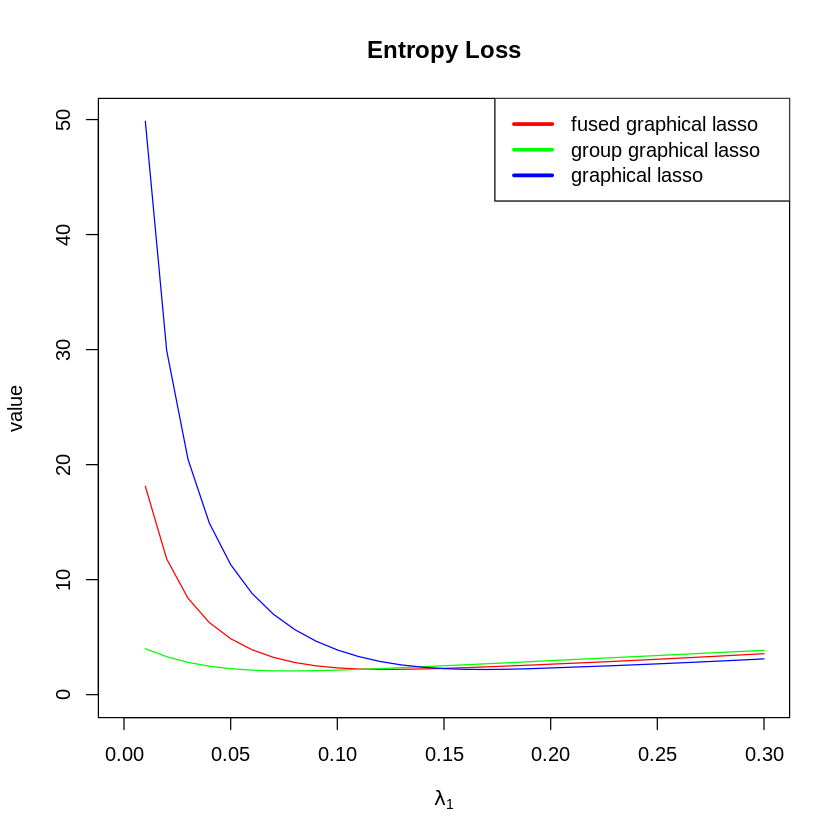

png 
  3

png 
  2

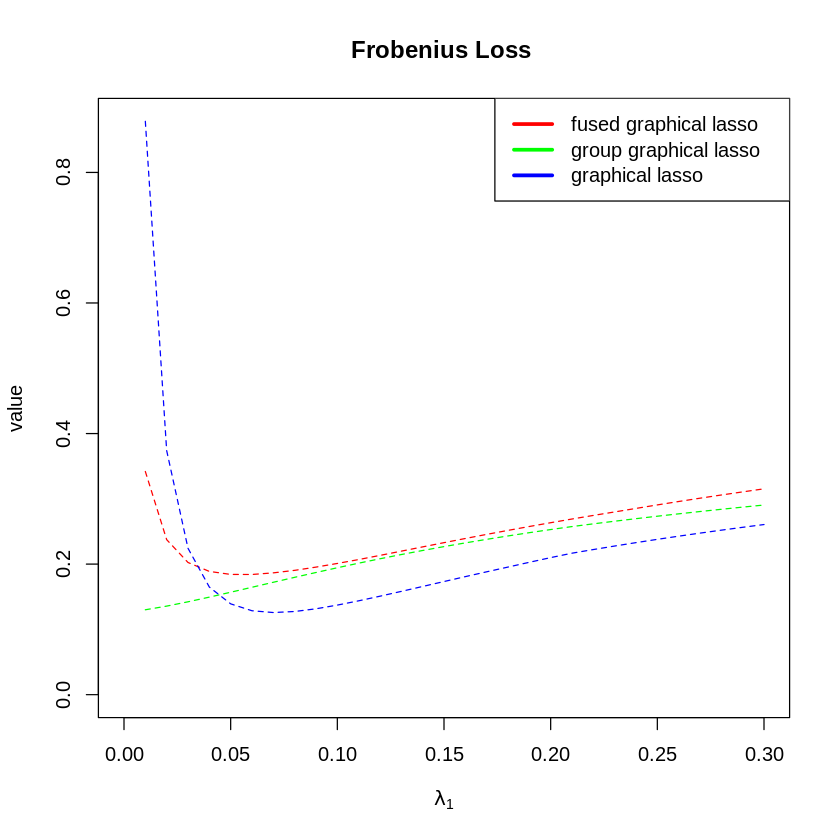

png 
  3

png 
  2

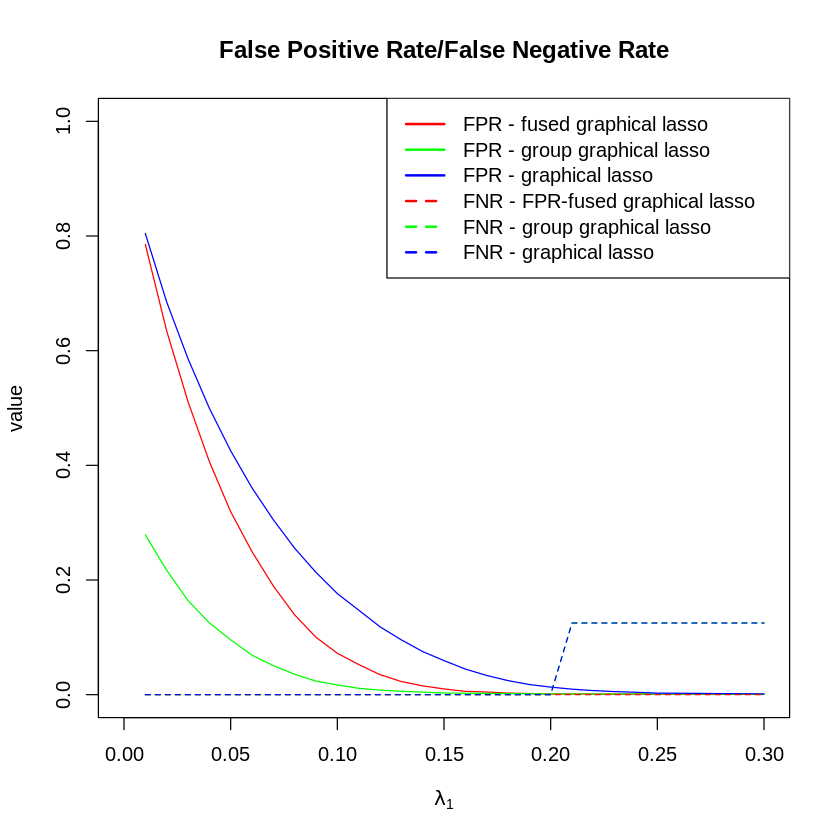

In [26]:
##########################
#    Entropy Loss        #
#                        #
##########################

cl <- rainbow(3)
plot(0,0,xlim = c(0.0,0.3),ylim = c(0,max(el_vec)),type = "n",xlab=TeX('$\\lambda_1$'),ylab="value",main="Entropy Loss")
lines(lambda.eff, el_vec[1,], col=cl[1], type="l") 
lines(lambda.eff, el_vec[2,], col=cl[2], type="l") 
lines(lambda.eff, el_vec[3,], col=cl[3], type="l") 

legend_txt <- c("fused graphical lasso","group graphical lasso","graphical lasso")
legend("topright", legend = legend_txt, col = cl, cex = 1, lwd = 3)
dev.copy(png, file=paste(path,ID,"_entropy_loss",".png",sep=""),width = 480, height = 480, units = "px", pointsize = 12)
dev.off()

############################
#    Frobenius Loss        #
#                          #
############################

cl <- rainbow(3)
plot(0,0,xlim = c(0.0,0.3),ylim = c(0,max(fr_vec)),type = "n",xlab=TeX('$\\lambda_1$'),ylab="value",main="Frobenius Loss ")
lines(lambda.eff, fr_vec[1,], col=cl[1], type="l",lty=2) 
lines(lambda.eff, fr_vec[2,], col=cl[2], type="l",lty=2) 
lines(lambda.eff, fr_vec[3,], col=cl[3], type="l",lty=2) 
legend_txt <- c("fused graphical lasso","group graphical lasso","graphical lasso")
legend("topright", legend = legend_txt, col = cl, cex = 1, lwd = 3)
dev.copy(png, file=paste(path,ID,"frobenius_loss",".png",sep=""),width = 480, height = 480, units = "px", pointsize = 12)
dev.off()

##########################
#          FPR,FNR       #
#                        #
##########################



cl <- rainbow(3)
plot(0,0,xlim = c(0.0,0.3),ylim = c(0,1.0),type = "n",xlab=TeX('$\\lambda_1$'),ylab="value",main="False Positive Rate/False Negative Rate")
lines(lambda.eff, fpr_vec[1,], col=cl[1], type="l") 
lines(lambda.eff, fpr_vec[2,], col=cl[2], type="l") 
lines(lambda.eff, fpr_vec[3,], col=cl[3], type="l") 
lines(lambda.eff, fnr_vec[1,], col=cl[1], type="l",lty=2) 
lines(lambda.eff, fnr_vec[2,], col=cl[2], type="l",lty=2) 
lines(lambda.eff, fnr_vec[3,], col=cl[3], type="l",lty=2) 
legend_txt <- c("FPR - fused graphical lasso","FPR - group graphical lasso","FPR - graphical lasso",
"FNR - FPR-fused graphical lasso","FNR - group graphical lasso","FNR - graphical lasso")
legend("topright", legend = legend_txt, col = cl, cex = 1, lwd = 2,lty=c(1,1,1,2,2,2))
dev.copy(png, file=paste(path,ID,"fpr_fnr",".png",sep=""),width = 480, height = 480, units = "px", pointsize = 12)
dev.off()

###  Akaike Information Criterion (AIC)
$vAIC(\lambda_1,\lambda_2)=\sum_{k=1}^K n_k tr(S^{(k)}\hat{\Theta}^{(k)}_{\lambda_1,\lambda_2})-n_k\log\det\hat{\Theta}^{(k)}_{\lambda_1,\lambda_2}+2E_k$

$S^{(k)}$ is the sampled covariance of group $k$

$\hat{\Theta}^{(k)}_{\lambda_1,\lambda_2}$ is the estimated inverse covariance matrix under parameters $\lambda_1,\lambda_2$

$E_k$ is the number of nonzero elements in $\hat{\Theta}^{(k)}_{\lambda_1,\lambda_2}$

perform grid search tuning the parameters

In [27]:
###########################################
#       Parameter Selection               #
#       BIC                               #
###########################################
BIC <- function(X, est_graph){
    num <- length(X)
    BIC_acc <- 0.
    for(i in 1:num){
        
        data_num <- dim(X[[i]])[1]
        sample_cov <- cov(X[[i]], X[[i]])
        tr_sum <- sum(diag(sample_cov %*% est_graph$theta[[i]]))

        log_det <- determinant(est_graph$theta[[i]], logarithm = TRUE)$modulus[1][1]

        E <- sum(sum(est_graph$theta[[i]] != 0.))
        log_data <- c(data_num*(tr_sum - log_det) , E)
       # print(log_data)
        BIC_acc <- BIC_acc + (tr_sum - log_det) + E
    }
    return(BIC_acc)
}

In [28]:
###########################################
#       Parameter Selection               #
#       Cross Validation                  #
###########################################
convert2list <- function(X,len){
    new_list <- list()
    for (i in 1:len){
        new_matrix <- X[,,i]
        new_list[i] <- list(new_matrix)
    }
}
CV <- function(X, D, method="fused", lam1, lam2){
    num <- length(X)
    n <- dim(X[[1]])[1]
    p <- dim(X[[1]])[2]
    CV_acc <- 0.
    X_matrix <- array(unlist(X),dim=c(n,p,length(X)))
    d_size <- as.integer(floor(n/D))
    for (d in 0:(D-1)){
        if(d != (D-1)){
            X_d <- X_matrix[(d_size*d+1):(d_size*(d+1)),,] 
            X_nod <- abind(X_matrix[0:(d_size*d),,], X_matrix[(d_size*(d+1)+1):n,,], along=1)           
        }
        else{
            X_d <- X_matrix[(d_size*d+1):n,,] 
            X_nod <- X_matrix[0:(d_size*d),,]           
        }
        X_nod <- convert2list(X_nod,num)
        fit <- JGL(Y=X_nod, penalty=method, lambda1=lam1, lambda2=lam2, return.whole.theta=TRUE) 
        for(k in 1:num){
            sample_cov <- cov(X_d[,,k],X_d[,,k])
            tr_sum <- sum(diag(sample_cov %*% fit$theta[[i]]))
            log_det <- determinant(fit$theta[[i]], logarithm = TRUE)$modulus[1][1]
            CV_acc <- CV_acc + (tr_sum-log_det)
        }
    }
    return(CV_acc)
}

In [29]:
###########################################
#       Parameter Selection               #
#       Akaike Information Criterion      #
#       #perform 2D grid search           #
###########################################
interval_l = 30
lambda.eff <- seq(0.01, 0.3, len = interval_l)
aic_vec <- matrix(NA, length(lambda.eff),length(lambda.eff))

for(i in 1:length(lambda.eff)){
    for(j in 1:length(lambda.eff)){
        fit00 <- JGL(Y=data,penalty="fused",lambda1=lambda.eff[i],lambda2=lambda.eff[j], return.whole.theta=TRUE) 
        aic_vec[i,j] <- vAIC(data, fit00)        
   }
}



png 
  3

png 
  2

[1] 26790.75

row,col
20,5


[1] "lambda_1 0.2"
[1] "lambda_2 0.05"


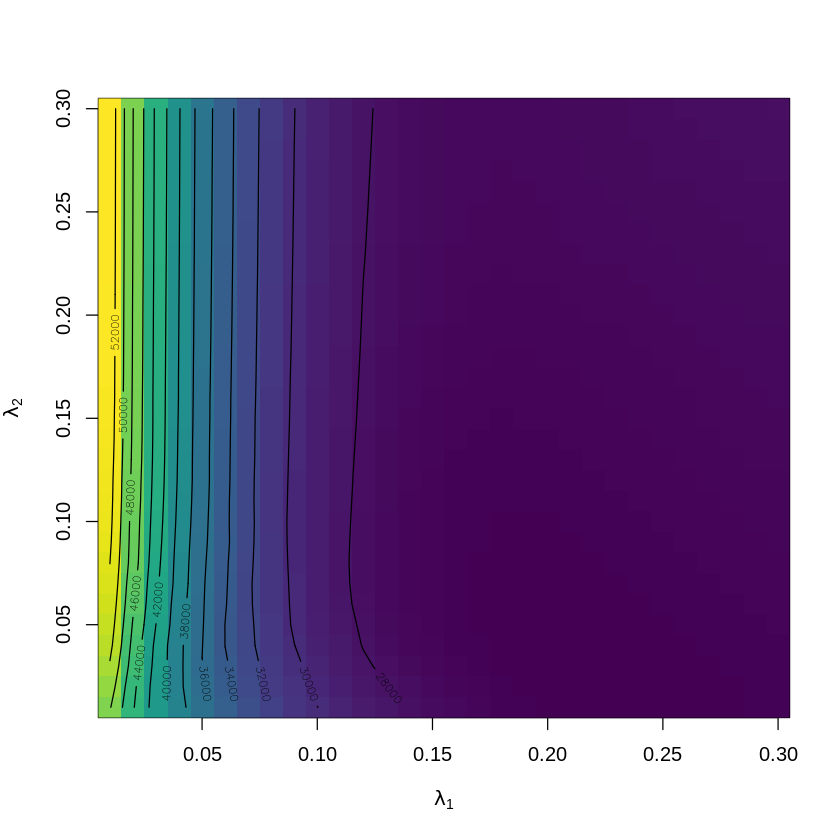

In [30]:
interval_l <- 30
lambda.eff <- seq(0.01, 0.3, len = interval_l)
image(x=lambda.eff,y=lambda.eff,z=aic_vec, col=viridis(256),
      ylab=TeX('$\\lambda_2$'),xlab=TeX('$\\lambda_1$'))
contour(x=lambda.eff,y=lambda.eff,z=aic_vec, add = TRUE,nlevels = 10)
dev.copy(png, file=paste(path,ID,"fgl_AIC",".png",sep=""),width = 480, height = 480, units = "px", pointsize = 12)
dev.off()
i_idx <- which(aic_vec == min(aic_vec), arr.ind = TRUE)[1,1]
j_idx <- which(aic_vec == min(aic_vec), arr.ind = TRUE)[1,2]

min(aic_vec)
 which(aic_vec == min(aic_vec), arr.ind = TRUE)

lam_1 <- lambda.eff[i_idx]
lam_2 <- lambda.eff[j_idx]

print(paste("lambda_1", lam_1))
print(paste("lambda_2", lam_2))

In [31]:
interval_l = 30
lambda.eff <- seq(0.01, 0.3, len = interval_l)
bic_vec <- matrix(NA, length(lambda.eff),length(lambda.eff))
for(i in 1:length(lambda.eff)){
    for(j in 1:length(lambda.eff)){
        fit00 <- JGL(Y=data,penalty="fused",lambda1=lambda.eff[i],lambda2=lambda.eff[j], return.whole.theta=TRUE) 
        bic_vec[i,j] <- vBIC(data, fit00)        
    }

}

png 
  3

png 
  2

[1] 184.1333

row,col
24,2


[1] "lambda_1 0.24"
[1] "lambda_2 0.02"


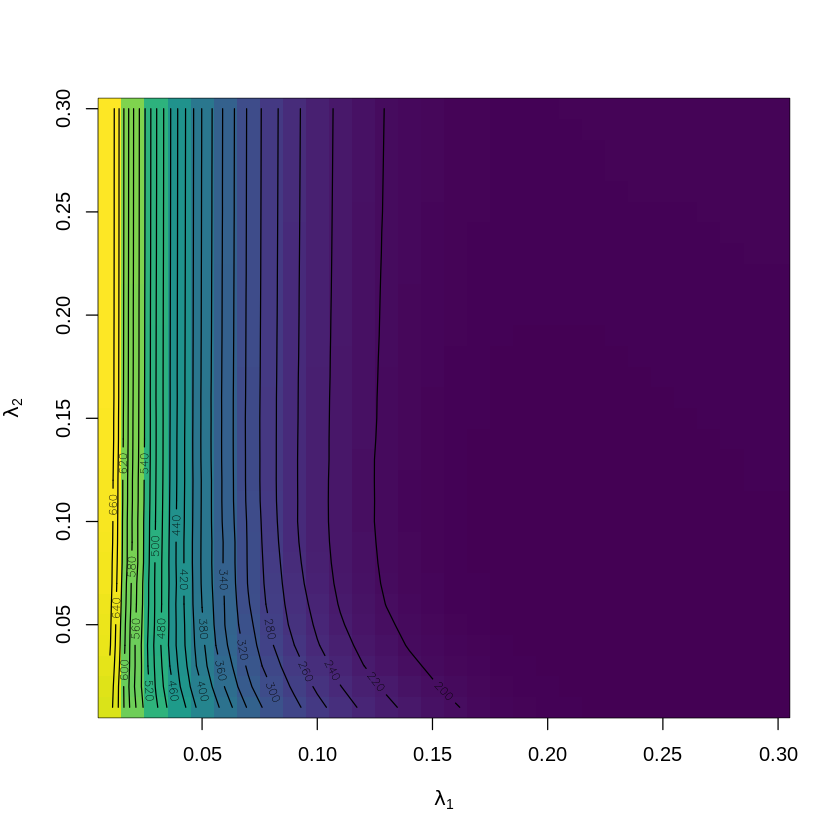

In [32]:
lambda.eff <- seq(0.01, 0.3, len = interval_l)
image(x=lambda.eff,y=lambda.eff,z=bic_vec, col=viridis(256),
      ylab=TeX('$\\lambda_2$'),xlab=TeX('$\\lambda_1$'))
contour(x=lambda.eff,y=lambda.eff,z=bic_vec, add = TRUE,nlevels = 20)
dev.copy(png, file=paste(path,ID,"fgl_BIC",".png",sep=""),width = 480, height = 480, units = "px", pointsize = 12)
dev.off()
i_idx <- which(bic_vec == min(bic_vec), arr.ind = TRUE)[1,1]
j_idx <- which(bic_vec == min(bic_vec), arr.ind = TRUE)[1,2]

min(bic_vec)
 which(bic_vec == min(bic_vec), arr.ind = TRUE)

lam_1 <- lambda.eff[i_idx]
lam_2 <- lambda.eff[j_idx]

print(paste("lambda_1", lam_1))
print(paste("lambda_2", lam_2))

#Note
#it seems like the AIC does not favor lamba_2

In [34]:
print("##################################################")
print("#    Fused Graphical Lasso (tuned parameters)    #")
print("##################################################")
print(paste("lambda_1", lam_1))
print(paste("lambda_2", lam_2))
fgl_t.results=JGL(Y=data,penalty="fused",lambda1=lam_1,lambda2=lam_2, return.whole.theta=TRUE) 
print(paste("Average entropy loss:", entropy_loss(fgl_t.results, graph, P, 2)))
print(paste("Average frobenious loss:", frobenious_loss(fgl_t.results, graph, 2)))
print(paste("Average false positive rate:", avg_fprfnr(fgl_t.results, graph, 2)[1]))
print(paste("Average false negative rate:", avg_fprfnr(fgl_t.results, graph, 2)[2]))
print("##################################################")
print("#             Result Visualization               #")
print("##################################################")
#show_result(fgl_t.results, graph, 4, method="fgl_tuned_001_BIC")

[1] "##################################################"
[1] "#    Fused Graphical Lasso (tuned parameters)    #"
[1] "##################################################"
[1] "lambda_1 0.24"
[1] "lambda_2 0.02"
[1] "Average entropy loss: 92.6190589316783"
[1] "Average frobenious loss: 0.242359169557449"
[1] "Average false positive rate: 0.00218161531250327"
[1] "Average false negative rate: 0.125"
[1] "##################################################"
[1] "#             Result Visualization               #"
[1] "##################################################"


In [35]:
###########################################
#       Parameter Selection               #
#       Akaike Information Criterion      #
#       #perform 2D grid search           #
###########################################
interval_l = 30
lambda.eff <- seq(0.01, 0.3, len = interval_l)
aic_g_vec <- matrix(NA, length(lambda.eff),length(lambda.eff))
for(i in 1:length(lambda.eff)){
    for(j in 1:length(lambda.eff)){
        fit00 <- JGL(Y=data,penalty="group",lambda1=lambda.eff[i],lambda2=lambda.eff[j], return.whole.theta=TRUE) 
        aic_g_vec[i,j] <- vAIC(data, fit00)        
    }

}

png 
  3

png 
  2

[1] 26742.52

[1] "lambda_1 0.05"
[1] "lambda_2 0.2"


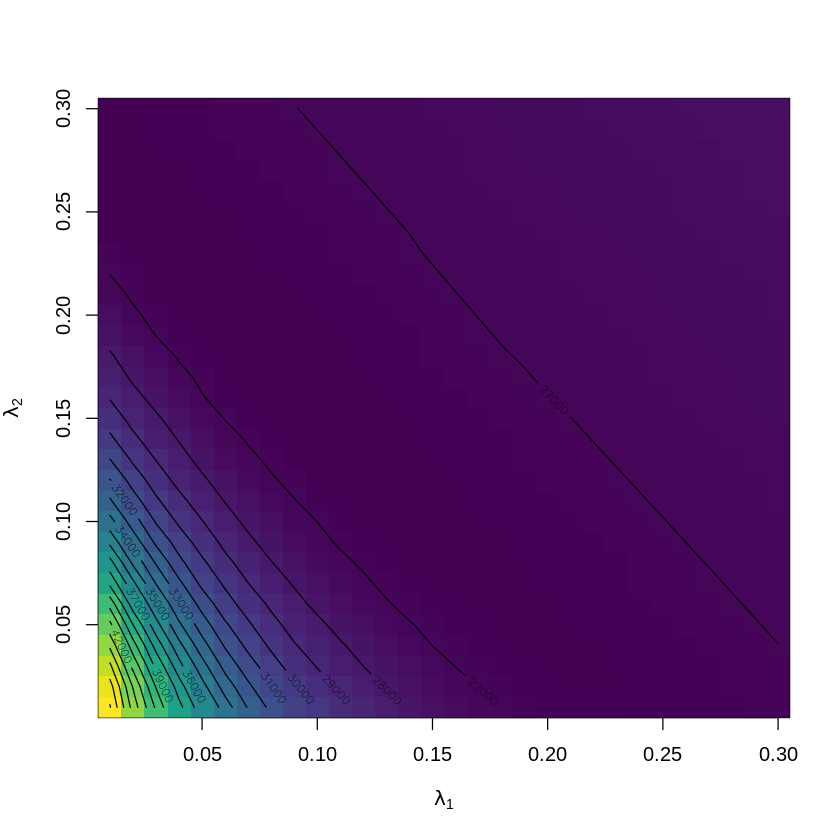

In [36]:
###########################################
#         group graphical lasso           #
###########################################
lambda.eff <- seq(0.01, 0.3, len = interval_l)

image(x=seq(0.01,0.3,0.01),y=seq(0.01,0.3,0.01),z=aic_g_vec, col=viridis(256),
      ylab=TeX('$\\lambda_2$'),xlab=TeX('$\\lambda_1$'))
contour(x=seq(0.01,0.3,0.01),y=seq(0.01,0.3,0.01),z=aic_g_vec, add = TRUE,nlevels = 20)
dev.copy(png, file=paste(path,"ggl_AIC",".png",sep=""),width = 480, height = 480, units = "px", pointsize = 12)
dev.off()
#axis(1, at = seq(0.01, 0.5, by = 0.01))
#axis(2, at = seq(0.01, 0.5, by = 0.01))

#heatmap(aic_vec, scale = "row",xlab=TeX('$\\lambda_1$'))
i_idx <- which(aic_g_vec == min(aic_g_vec), arr.ind = TRUE)[1]
j_idx <- which(aic_g_vec == min(aic_g_vec), arr.ind = TRUE)[2]

min(aic_g_vec)


lam_1 <- lambda.eff[i_idx]
lam_2 <- lambda.eff[j_idx]

print(paste("lambda_1", lam_1))
print(paste("lambda_2", lam_2))

In [42]:


print("##################################################")
print("#    Group Graphical Lasso (tuned parameters)    #")
print("##################################################")
print(paste("lambda_1", lam_1))
print(paste("lambda_2", lam_2))
ggl_t.results=JGL(Y=data,penalty="group",lambda1=lam_1,lambda2=lam_2, return.whole.theta=TRUE) 
print(paste("Average entropy loss:", entropy_loss(ggl_t.results, graph, P, 2)))
print(paste("Average frobenious loss:", frobenious_loss(ggl_t.results, graph, 2)))
print(paste("Average false positive rate:", avg_fprfnr(ggl_t.results, graph, 2)[1]))
print(paste("Average false negative rate:", avg_fprfnr(ggl_t.results, graph, 2)[2]))
print("##################################################")
print("#             Result Visualization               #")
print("##################################################")
#show_result(ggl_t.results, graph, 2, method="ggl_t_tuned")


[1] "##################################################"
[1] "#    Group Graphical Lasso (tuned parameters)    #"
[1] "##################################################"
[1] "lambda_1 0.05"
[1] "lambda_2 0.2"
[1] "Average entropy loss: 92.3450365491171"
[1] "Average frobenious loss: 0.213841148865453"
[1] "Average false positive rate: 0.00396609081787763"
[1] "Average false negative rate: 0"
[1] "##################################################"
[1] "#             Result Visualization               #"
[1] "##################################################"


In [43]:
###########################################
#       Parameter Selection               #
#       Akaike Information Criterion      #
#       #perform 2D grid search           #
###########################################
interval_l = 50
lambda.eff <- seq(0.01, 1., len = interval_l)
aic_gl_vec <- rep(NA, length(lambda.eff))
for(i in 1:length(lambda.eff)){
        fit00 <- JGL(Y=data,penalty="fused",lambda1=lambda.eff[i],lambda2=0., return.whole.theta=TRUE) 
        aic_gl_vec[i] <- vAIC(data, fit00)        

}

In [44]:
###########################################
#             graphical lasso             #
###########################################

#image(z=aic_gl_vec, col=viridis(256),xlab=TeX('$\\lambda_1$'))
#dev.copy(png, file=paste(path,"gl_AIC",".png",sep=""),width = 480, height = 480, units = "px", pointsize = 12)
#dev.off()

i_idx <- which.min(aic_gl_vec) 

lam_1 <- lambda.eff[i_idx]

print(paste("optimal lambda_1", lam_1))

[1] "optimal lambda_1 0.252448979591837"


In [45]:
print("##################################################")
print("#       Graphical Lasso (tuned parameters)      #")
print("##################################################")
print(paste("optimal lambda_1", lam_1))
gl_t.results=JGL(Y=data,penalty="fused",lambda1=lam_1,lambda2=0., return.whole.theta=TRUE) 
print(paste("Average entropy loss:", entropy_loss(ggl_t.results, graph, P, 2)))
print(paste("Average frobenious loss:", frobenious_loss(gl_t.results, graph, 2)))
print(paste("Average false positive rate:", avg_fprfnr(gl_t.results, graph, 2)[1]))
print(paste("Average false negative rate:", avg_fprfnr(gl_t.results, graph, 2)[2]))
print("##################################################")
print("#             Result Visualization               #")
print("##################################################")
#show_result(gl_t.results, graph, 2, method="gl_t_tuned")

[1] "##################################################"
[1] "#       Graphical Lasso (tuned parameters)      #"
[1] "##################################################"
[1] "optimal lambda_1 0.252448979591837"
[1] "Average entropy loss: 92.3450365491171"
[1] "Average frobenious loss: 0.239138908235356"
[1] "Average false positive rate: 0.00257826370727926"
[1] "Average false negative rate: 0.125"
[1] "##################################################"
[1] "#             Result Visualization               #"
[1] "##################################################"
